In [1]:
import pandas as pd
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
#from pytorch_lightning import LightningModule, Trainer
import matplotlib.pyplot as plt
import time 
from sklearn.metrics import roc_curve, auc
import torch.optim as optim
from torchmetrics.classification import MulticlassCohenKappa
from sklearn.metrics import cohen_kappa_score
from torch.nn.utils.rnn import pad_sequence
from sleep_datasets import SleepDataset, SleepChunkDataset
from sklearn.utils.class_weight import compute_class_weight

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Construct Dataset Class

### Split Subjects into Train/Val/Test

In [2]:
participant_info_df = pd.read_csv('/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/participant_info.csv')
subjects_all = participant_info_df['SID']

subjects_all_shuffled = participant_info_df['SID'].sample(frac=1, random_state=42).reset_index(drop=True)
subjects_train = subjects_all_shuffled[:int(len(subjects_all_shuffled)*0.7)]
subjects_val = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.7):int(len(subjects_all_shuffled)*0.9)]
subjects_test = subjects_all_shuffled[int(len(subjects_all_shuffled)*0.9):]
print(f"number of subjects in train: {len(subjects_train)}")
print(f"number of subjects in val: {len(subjects_val)}")
print(f"number of subjects in test: {len(subjects_test)}")

# overwrite with smaller dataset for development (20% of original)
fraction = 0.3
subjects_train_small = subjects_train[:int(len(subjects_train)*fraction)]
subjects_val_small = subjects_val[:int(len(subjects_val)*fraction)]
subjects_test_small = subjects_test[:int(len(subjects_test)*fraction)]
print(f"number of subjects in small train: {len(subjects_train_small)}")
print(f"number of subjects in small val: {len(subjects_val_small)}")
print(f"number of subjects in small test: {len(subjects_test_small)}")

number of subjects in train: 70
number of subjects in val: 20
number of subjects in test: 10
number of subjects in small train: 21
number of subjects in small val: 6
number of subjects in small test: 3


### Initialize DataLoaders (big, full sequence @ 64hz)

In [ ]:
target_freq = 64
datadir_64Hz = "/scratch/npr264/BioDeepL/dreamt/physionet.org/files/dreamt/2.0.0/data_64Hz"
max_length = 1228800
train_dataset = SleepDataset(subjects_list=subjects_train,
                                 data_dir=datadir_64Hz,
                                 max_length=max_length,
                                 downsample_freq=target_freq, # downsample to 8Hz
                                 debug=False)
print(f"Total samples in train dataset: {len(train_dataset)}")
val_dataset = SleepDataset(subjects_list=subjects_val,
                                 data_dir=datadir_64Hz,
                                 max_length=max_length,
                                 downsample_freq=target_freq, # downsample to 8Hz
                                 debug=False)
print(f"Total samples in val dataset: {len(val_dataset)}")                                 
test_dataset = SleepDataset(subjects_list=subjects_test,
                                 data_dir=datadir_64Hz,
                                 max_length=max_length,
                                 downsample_freq=target_freq, # downsample to 8Hz
                                 debug=False)
print(f"Total samples in test dataset: {len(test_dataset)}")

#### Class Representation in train/test/val sets

In [7]:
train_labels = np.concatenate([train_dataset.__getitem__(i)[1].numpy().ravel() for i in range(train_dataset.__len__())])
val_labels = np.concatenate([val_dataset.__getitem__(i)[1].numpy().ravel() for i in range(val_dataset.__len__())])
test_labels = np.concatenate([test_dataset.__getitem__(i)[1].numpy().ravel() for i in range(test_dataset.__len__())])

print(f"Sleep stage representation in train set:\n{pd.Series(train_labels).value_counts(normalize=True)}")
print(f"Sleep stage representation in val set:\n{pd.Series(val_labels).value_counts(normalize=True)}")
print(f"Sleep stage representation in test set:\n{pd.Series(test_labels).value_counts(normalize=True)}")

Sleep stage representation in train set:
 1    0.616563
 0    0.254866
 3    0.087701
 2    0.039554
-1    0.001317
Name: proportion, dtype: float64
Sleep stage representation in val set:
1    0.627891
0    0.230469
3    0.080937
2    0.060703
Name: proportion, dtype: float64
Sleep stage representation in test set:
 1    0.522500
 0    0.406719
 3    0.065156
 2    0.005469
-1    0.000156
Name: proportion, dtype: float64


In [8]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.arange(4), y=train_labels[train_labels!=-1])

### Construct SleepPPG-Net Blocks

In [10]:
#res conv module to be used in the ResConv stack
class ResConv(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, kernel_size=3, pool_size=2, padding = 1):
        super(ResConv, self).__init__()
        conv_layers = nn.ModuleList([nn.Conv1d(in_channels, out_channels, kernel_size, padding=(kernel_size - 1) // 2, dtype=torch.float32)]+[nn.Conv1d(out_channels, out_channels, kernel_size, padding=(kernel_size - 1) // 2, dtype=torch.float32) for i in range(num_layers-1)])
        self.conv = nn.Sequential(*conv_layers)
        #self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=(kernel_size - 1) // 2, dtype=torch.float32)     
        #self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=(kernel_size - 1) // 2)        
        #self.conv3 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=(kernel_size - 1) // 2)
        
        self.pool = nn.MaxPool1d(kernel_size=pool_size)
        self.norm = nn.BatchNorm1d(out_channels)
        # Project input if in_channels ≠ out_channels
        self.needs_shortcut = in_channels != out_channels
        self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.activation = nn.LeakyReLU(0.1)
        self._initialize_weights()
        self.dropout = nn.Dropout(0.05)
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)              
    def forward(self, x):
        if self.needs_shortcut:
            residual = self.shortcut(x)
        else:
            residual = x
        #out = self.conv1(x)
        #out = self.conv2(out)
        #out = self.norm(out)
        #out = self.conv3(out)
        #out = self.activation(out)
        out = self.conv(x)
        out = self.pool(out)
        residual = self.pool(residual)

        out += residual
        out = self.dropout(out)
        return self.activation(out)
        
#temporal windowing block
class TemporalWindow(nn.Module):
    def __init__(self, window_size):
        super().__init__()
        self.window_size = window_size

    def forward(self, x):
        batch_size, C, L = x.shape
        x = x.reshape(batch_size, -1, self.window_size)
        return x

#time distributed dnn block
class TimeDistributed(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super(TimeDistributed, self).__init__()
        self.module = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.LeakyReLU(0.1),
            nn.Dropout(dropout)
        )
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # x: [batch_size, time_steps, input_dim]
        batch_size, input_dim, time_steps = x.size()
        x_reshaped = x.contiguous().view(-1, input_dim) # Flatten batch and time: [batch_size * time_steps, input_dim]
        y = self.module(x_reshaped)         # Apply module
        output_dim = y.size(-1)         # Reshape back to [batch_size, time_steps, output_dim]
        y = y.view(batch_size, output_dim, time_steps)
        return y

#TCN block
class TCNBlock(nn.Module):
    def __init__(self, tcn_depth, in_channels, out_channels, kernel_size=7, dropout=0.1):
        super(TCNBlock, self).__init__()

        self.dropout = nn.Dropout(dropout)
        dilation_rates = [1,2,4,8,16,32]
        conv_layers = nn.ModuleList([nn.Conv1d(in_channels, in_channels, kernel_size, padding=(kernel_size - 1) * dilation_rates[i] // 2, dilation = dilation_rates[i]) for i in range(tcn_depth)])
        self.conv = nn.Sequential(*conv_layers)

        #self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size, padding=(kernel_size - 1) * 1 // 2, dilation=1)        
        #self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size, padding=(kernel_size - 1) * 2 // 2, dilation=2)        
        #self.conv3 = nn.Conv1d(in_channels, in_channels, kernel_size, padding=(kernel_size - 1) * 4 // 2, dilation=4)        
        #self.conv4 = nn.Conv1d(in_channels, in_channels, kernel_size, padding=(kernel_size - 1) * 8 // 2, dilation=8)        
        #self.conv5 = nn.Conv1d(in_channels, in_channels, kernel_size, padding=(kernel_size - 1) * 16 // 2, dilation=16)         
        #self.conv6 = nn.Conv1d(in_channels, in_channels, kernel_size, padding=(kernel_size - 1) * 32 // 2, dilation=32)
        #self.norm = nn.BatchNorm1d(in_channels)
        self.residual = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        self.activation = nn.LeakyReLU(0.1)
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        residual = self.residual(x)
        #out = self.conv1(x) #conv1
        #out = self.dropout(out)
        #out = self.conv2(out) #conv2
        #out = self.conv3(out) #conv3
        #out = self.conv4(out) #conv2
        #out = self.norm(out)
        #out = self.conv5(out) #conv2
        #out = self.norm(out)
        #out = self.conv6(out) #conv2
        #out = self.norm(out)
        out = self.conv(x)
        out = out + residual
        out = self.dropout(out)
        return self.activation(out)

#prediction block
class PredictConv(nn.Module):
    def __init__(self, in_channels, num_classes, kernel_size=1):
        super(PredictConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, num_classes, kernel_size)
       
    def forward(self, x):
        out = self.conv(x) 
        return out

### Construct Sleep Staging Model

In [11]:

class SleepStager(nn.Module):
    def __init__(self, flist_resconv, resconv_depth, resconv_kernel_size, h_dnn, o_dnn, num_layers_tcn, tcn_depth, tcn_kernel_size, output_dim, seq_length, window_size, dropout):
        super(SleepStager, self).__init__()
    
        self.flist_resconv = flist_resconv #must start with 1, then specify output filter size for all intended resconv layers in the block (i.e for 8 filters this list should be 9 elements long)
        self.n_resconv_layers = len(flist_resconv) - 1
        self.in_dnn = int(((seq_length/(2**self.n_resconv_layers))/window_size)*flist_resconv[-1])
        
        #resconv block
        self.resconv = nn.ModuleList([ResConv(resconv_depth, flist_resconv[i-1], flist_resconv[i], kernel_size=resconv_kernel_size, pool_size=2) for i in range(1,len(flist_resconv))])
        
        #temporal window block
        self.temp_window = TemporalWindow(window_size=window_size)

        #time distributed dnn block 
        self.dnn = TimeDistributed(self.in_dnn, h_dnn, o_dnn, dropout) #1024 = dimension size from temporal window (fixed), 512 = hidden dimension size (learnable), 128 = output dim size (fixed)

        #TCN block
        self.tcn = nn.ModuleList([TCNBlock(tcn_depth, o_dnn, o_dnn, kernel_size=tcn_kernel_size, dropout = dropout) for i in range(num_layers_tcn)])

        #final conv layer for prediction 
        self.predconv = PredictConv(o_dnn, output_dim, kernel_size=1)
        self.activation = nn.LeakyReLU(0.1)
        
    def forward(self, x): #x shape: [batch_size, 1, 1228800]
        out = x
        for resconv in self.resconv: # shape: [batch_size, Frc8, 4800]
            out = resconv(out)
        #print(f"res conv: {out.shape}")
        out = self.temp_window(out) #shape: [batch_size, self.in_dnn, 1200]
        #print(f"temp window: {out.shape}")
        out = self.dnn(out) #shape: [batch_size, 128, 1200]
        #print(f"dnn: {out.shape}")
        for tcn in self.tcn: #shape: [batch_size, 128, 1200]
            out = tcn(out)
        out = self.predconv(out) #shape: [batch_size, 4, 1200]
        return out

### Define model training loop

In [12]:
def row_mode(row):
    vals, counts = np.unique(row, return_counts=True)
    return vals[np.argmax(counts)]

def resize_labels_predictions(outputs, labels, device):
    batch_size, num_classes, num_windows = outputs.shape
    window_size = labels.shape[1]//num_windows
    idx = torch.linspace(0, labels.shape[1] - 1, num_windows).long()
    y_resampled = labels[:, idx].squeeze(1).long()
    y_hat = outputs.reshape(batch_size * num_windows, num_classes)
    y_true = y_resampled.reshape(batch_size * num_windows,).long().to(device)
    return y_hat, y_true

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = []
    epoch_acc = []
    model.train()
    batch_counter = 0
    start_time = time.time()
#    torch.cuda.reset_peak_memory_stats(device)
    for sequences, labels in iterator:
        labels = labels.to(device)
        sequences = sequences.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        
        y_hat, y_true = resize_labels_predictions(outputs, labels, device)
        loss = criterion(y_hat, y_true)
        acc = calculate_accuracy(y_hat, y_true)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if not torch.isnan(loss):   
            epoch_loss.append(loss.item())
            epoch_acc.append(acc)
        batch_counter += 1
    train_time = time.time() - start_time
    peak_memory = 0#torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to MB
    print(f"train time: {train_time:.2f}, train memory: {peak_memory:.2f}")
    return np.mean(epoch_loss), np.mean(epoch_acc)

def evaluate(model, iterator, criterion, device):
    start_time = time.time()
    epoch_loss = []
    epoch_acc = []
    y_hats = []
    y_trues = []
    
    model.eval()
    start_time = time.time()
    
  #  torch.cuda.reset_peak_memory_stats(device)
    with torch.no_grad():
        for sequences, labels in iterator:
            labels = labels
            sequences = sequences.to(device)
            outputs = model(sequences)
            
            y_hat, y_true = resize_labels_predictions(outputs, labels, device)
            loss = criterion(y_hat, y_true)
            acc = calculate_accuracy(y_hat, y_true)
            
            if not torch.isnan(loss):   
                epoch_loss.append(loss.item())
                epoch_acc.append(acc)
                y_hats.append(y_hat)
                y_trues.append(y_true)
    
    y_hats = torch.vstack(y_hats)
    y_trues = torch.hstack(y_trues)
    cohens_kappa = compute_cohens_kappa(y_hats, y_trues)
    epoch_time = time.time() - start_time 
    peak_memory = 0 #torch.cuda.max_memory_allocated(device) / (1024 ** 2)  # Convert to MB
    print(f"test time: {epoch_time:.2f}, test memory: {peak_memory:.2f}")
    return np.mean(epoch_loss), np.mean(epoch_acc), cohens_kappa, y_hats, y_trues

def compute_cohens_kappa(logits, labels):
    predicted_class = np.argmax(F.softmax(logits.cpu().detach(),dim=1).numpy(),axis=1)
    labs = labels.cpu().detach().numpy()

    mask = np.argwhere(labs == -1).flatten()
    if len(mask) != 0:
        predicted_masked = predicted_class[~mask]
        labs_masked = labs[~mask]
    else:
        predicted_masked = predicted_class
        labs_masked = labs
    return cohen_kappa_score(labs_masked, predicted_masked)

def calculate_accuracy(logits, labels):
    #_, predicted_classes = torch.max(predictions, 1)
    logits = logits.cpu()
    labs = labels.cpu().numpy()

    #drop predictions and labels where label is -1 (missing) 
    logits = logits[labs != -1]
    labs = labs[labs != -1]
    
    predicted_classes = np.argmax(F.softmax(logits, dim=1).detach().numpy(),axis=1)
    correct_predictions = (predicted_classes == labs).sum()
    accuracy = correct_predictions / len(labs)  # Corrected line
    return accuracy
def plot_roc_curve(labels, logits):
    """
    Compute AUC and plot the ROC curve.
    
    :param labels: Array of true labels (binary: 0 or 1)
    :param scores: Array of predicted scores (probabilities)
    """
    # Compute False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
    scores = torch.sigmoid(torch.tensor(logits)).numpy()
    fpr, tpr, _ = roc_curve(labels, scores)
    
    # Compute AUC score
    roc_auc = auc(fpr, tpr)

    # Compute accuracy 
    predictions = np.ones(len(scores))
    predictions[scores <= 0.5] = 0
    accuracy = (predictions == labels).sum()/len(predictions)
    
    return fpr, tpr, roc_auc, accuracy

### Tune Hyperparameters

In [13]:
import optuna
def objective(trial):
    NUM_LAYERS_RESCONV = trial.suggest_int("NUM_LAYERS_RESCONV", 1, 8)
    FILTERS_RESCONV_ALL = [1, 16, 16, 32, 32, 64, 64, 128, 256]
    RESCONV_KERNEL_SIZE = trial.suggest_categorical("RESCONV_KERNEL_SIZE", [1, 3, 5])
    RESCONV_DEPTH = trial.suggest_int("RESCONV_DEPTH", 1, 4)
    FILTERS_RESCONV = FILTERS_RESCONV_ALL[:NUM_LAYERS_RESCONV+1]
    HIDDEN_DNN = 64
    OUT_DNN = trial.suggest_categorical("OUT_DNN", [16, 32, 64,128])
    NUM_LAYERS_TCN = trial.suggest_int("NUM_LAYERS_TCN", 1, 4)
    TCN_KERNEL_SIZE = trial.suggest_categorical("TCN_KERNEL_SIZE", [1, 3, 5, 7, 9])
    TCN_DEPTH =  trial.suggest_int("TCN_DEPTH", 1, 6)
    SEQ_LENGTH = 1228800
    WINDOW_SIZE = 1200
    BATCH_SIZE = 4
    OUTPUT_DIM = 4
    NUM_EPOCHS = 20
    DROPOUT = trial.suggest_float("DROPOUT", 0.01, 0.25)
    LABEL_SMOOTHING = trial.suggest_float("LABEL_SMOOTHING", 1e-2, 0.1)
    lr = trial.suggest_float("lr", 1e-5, 1e-2)
    WEIGHT_DECAY = trial.suggest_float("WEIGHT_DECAY", 1e-5, 1e-2)
    
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = SleepStager(FILTERS_RESCONV, RESCONV_DEPTH, RESCONV_KERNEL_SIZE, HIDDEN_DNN, OUT_DNN, NUM_LAYERS_TCN, TCN_DEPTH, TCN_KERNEL_SIZE, OUTPUT_DIM, SEQ_LENGTH, WINDOW_SIZE, DROPOUT).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = WEIGHT_DECAY)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=len(train_dataloader), epochs=NUM_EPOCHS, pct_start=0.3)
    
    #criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
    #criterion = nn.CrossEntropyLoss(ignore_index=-1, weight = torch.tensor(class_weights,dtype=torch.float32).to(device),label_smoothing=LABEL_SMOOTHING)
    criterion = nn.CrossEntropyLoss(ignore_index=-1, label_smoothing=LABEL_SMOOTHING)

    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    valid_logits = []
    valid_labels = []
    kappas = []
    
    for epoch in range(NUM_EPOCHS):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
        valid_loss, valid_acc, cohens_kappa, valid_logit, valid_label = evaluate(model, val_dataloader, criterion, device)
        #scheduler.step()
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
        valid_logits.append(valid_logit)
        valid_labels.append(valid_label)
        kappas.append(cohens_kappa)
        print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.4f}, Val. Acc: {valid_acc*100:.2f}%')

        #early stopping
        if epoch > 4:
            val_loss_arr = np.array(valid_losses)
            val_loss_pct_change = np.diff(val_loss_arr)*100/val_loss_arr[:-1] 
            if (np.abs(val_loss_pct_change[-3:]) >= 0.5).sum() == 0: # none of the last 3 epochs have validation loss gt 0.5% 
                break
        
        trial.report(valid_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return valid_loss

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
print(f"Best trial: {study.best_trial}\nValidation Loss: {study.best_trial.value}\nBest hyperparameters: {study.best_trial.params}")

/ext3/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-30 12:23:07,794] A new study created in memory with name: no-name-d10954f4-2428-439a-8444-14e5c643cf55


train time: 10.76, train memory: 0.00
test time: 0.69, test memory: 0.00
Epoch: 01, Train Loss: 1.2860, Train Acc: 45.73%, Val. Loss: 1.0721, Val. Acc: 65.68%
train time: 3.44, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 02, Train Loss: 1.0601, Train Acc: 63.20%, Val. Loss: 1.0237, Val. Acc: 65.65%
train time: 3.45, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 03, Train Loss: 1.0411, Train Acc: 62.97%, Val. Loss: 1.0126, Val. Acc: 65.57%
train time: 3.45, train memory: 0.00
test time: 0.70, test memory: 0.00
Epoch: 04, Train Loss: 1.0284, Train Acc: 64.04%, Val. Loss: 1.0308, Val. Acc: 64.98%
train time: 3.47, train memory: 0.00
test time: 0.63, test memory: 0.00
Epoch: 05, Train Loss: 1.0313, Train Acc: 63.75%, Val. Loss: 1.0235, Val. Acc: 65.55%
train time: 3.46, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 06, Train Loss: 1.0255, Train Acc: 64.31%, Val. Loss: 1.0276, Val. Acc: 65.79%
train time: 3.37, train memory: 0.00
test time: 0.6

[I 2025-04-30 12:24:37,711] Trial 0 finished with value: 1.0149571895599365 and parameters: {'NUM_LAYERS_RESCONV': 8, 'RESCONV_KERNEL_SIZE': 3, 'RESCONV_DEPTH': 1, 'OUT_DNN': 16, 'NUM_LAYERS_TCN': 1, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 1, 'DROPOUT': 0.1133955216172325, 'LABEL_SMOOTHING': 0.0760201898129106, 'lr': 0.008848303218627836}. Best is trial 0 with value: 1.0149571895599365.


test time: 0.70, test memory: 0.00
Epoch: 20, Train Loss: 1.0179, Train Acc: 64.01%, Val. Loss: 1.0150, Val. Acc: 65.48%
train time: 2.63, train memory: 0.00
test time: 0.65, test memory: 0.00
Epoch: 01, Train Loss: 1.3029, Train Acc: 53.42%, Val. Loss: 1.0910, Val. Acc: 60.65%
train time: 2.65, train memory: 0.00
test time: 0.69, test memory: 0.00
Epoch: 02, Train Loss: 1.0807, Train Acc: 58.63%, Val. Loss: 1.0150, Val. Acc: 62.61%
train time: 2.67, train memory: 0.00
test time: 0.68, test memory: 0.00
Epoch: 03, Train Loss: 1.0047, Train Acc: 61.49%, Val. Loss: 1.0550, Val. Acc: 62.84%
train time: 2.66, train memory: 0.00
test time: 0.66, test memory: 0.00
Epoch: 04, Train Loss: 1.0104, Train Acc: 62.18%, Val. Loss: 1.0375, Val. Acc: 63.95%
train time: 2.63, train memory: 0.00
test time: 0.65, test memory: 0.00
Epoch: 05, Train Loss: 1.0008, Train Acc: 61.74%, Val. Loss: 1.0093, Val. Acc: 63.03%
train time: 2.68, train memory: 0.00
test time: 0.68, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:25:30,834] Trial 1 finished with value: 0.9935419440269471 and parameters: {'NUM_LAYERS_RESCONV': 2, 'RESCONV_KERNEL_SIZE': 3, 'RESCONV_DEPTH': 3, 'OUT_DNN': 64, 'NUM_LAYERS_TCN': 1, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 1, 'DROPOUT': 0.04866644432219783, 'LABEL_SMOOTHING': 0.02724638820871502, 'lr': 0.006388963071915838}. Best is trial 1 with value: 0.9935419440269471.


test time: 0.65, test memory: 0.00
Epoch: 16, Train Loss: 1.0017, Train Acc: 62.49%, Val. Loss: 0.9935, Val. Acc: 63.53%
train time: 2.99, train memory: 0.00
test time: 0.66, test memory: 0.00
Epoch: 01, Train Loss: 1.2651, Train Acc: 54.27%, Val. Loss: 1.1540, Val. Acc: 62.48%
train time: 2.97, train memory: 0.00
test time: 0.65, test memory: 0.00
Epoch: 02, Train Loss: 1.0939, Train Acc: 58.11%, Val. Loss: 1.0818, Val. Acc: 62.62%
train time: 2.99, train memory: 0.00
test time: 0.62, test memory: 0.00
Epoch: 03, Train Loss: 1.0684, Train Acc: 60.31%, Val. Loss: 1.0633, Val. Acc: 62.66%
train time: 2.96, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 04, Train Loss: 1.0763, Train Acc: 61.38%, Val. Loss: 1.1038, Val. Acc: 62.66%
train time: 3.05, train memory: 0.00
test time: 0.65, test memory: 0.00
Epoch: 05, Train Loss: 1.0588, Train Acc: 59.73%, Val. Loss: 1.0770, Val. Acc: 62.66%
train time: 3.01, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:26:44,441] Trial 2 finished with value: 1.020533013343811 and parameters: {'NUM_LAYERS_RESCONV': 4, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 1, 'OUT_DNN': 128, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 1, 'TCN_DEPTH': 5, 'DROPOUT': 0.08954555576795195, 'LABEL_SMOOTHING': 0.05156419328397401, 'lr': 0.0034750707716250805}. Best is trial 1 with value: 0.9935419440269471.


test time: 0.63, test memory: 0.00
Epoch: 20, Train Loss: 1.0141, Train Acc: 63.49%, Val. Loss: 1.0205, Val. Acc: 64.35%
train time: 2.79, train memory: 0.00
test time: 0.64, test memory: 0.00
Epoch: 01, Train Loss: 1.2532, Train Acc: 48.78%, Val. Loss: 1.0566, Val. Acc: 62.75%
train time: 2.74, train memory: 0.00
test time: 0.64, test memory: 0.00
Epoch: 02, Train Loss: 1.0766, Train Acc: 60.57%, Val. Loss: 1.0737, Val. Acc: 62.67%
train time: 2.76, train memory: 0.00
test time: 0.64, test memory: 0.00
Epoch: 03, Train Loss: 1.0173, Train Acc: 60.94%, Val. Loss: 1.0343, Val. Acc: 63.92%
train time: 2.80, train memory: 0.00
test time: 0.64, test memory: 0.00
Epoch: 04, Train Loss: 1.0123, Train Acc: 61.81%, Val. Loss: 0.9966, Val. Acc: 62.66%
train time: 2.81, train memory: 0.00
test time: 0.60, test memory: 0.00
Epoch: 05, Train Loss: 1.0073, Train Acc: 62.80%, Val. Loss: 0.9976, Val. Acc: 65.72%
train time: 2.80, train memory: 0.00
test time: 0.61, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:27:50,030] Trial 3 finished with value: 1.0004598736763 and parameters: {'NUM_LAYERS_RESCONV': 3, 'RESCONV_KERNEL_SIZE': 3, 'RESCONV_DEPTH': 1, 'OUT_DNN': 16, 'NUM_LAYERS_TCN': 1, 'TCN_KERNEL_SIZE': 9, 'TCN_DEPTH': 2, 'DROPOUT': 0.021421794217457588, 'LABEL_SMOOTHING': 0.038289243915029005, 'lr': 0.005338336778716697}. Best is trial 1 with value: 0.9935419440269471.


test time: 0.64, test memory: 0.00
Epoch: 20, Train Loss: 1.0057, Train Acc: 61.74%, Val. Loss: 1.0005, Val. Acc: 65.67%
train time: 4.73, train memory: 0.00
test time: 0.78, test memory: 0.00
Epoch: 01, Train Loss: 1.1435, Train Acc: 54.43%, Val. Loss: 1.0154, Val. Acc: 62.66%
train time: 4.76, train memory: 0.00
test time: 0.84, test memory: 0.00
Epoch: 02, Train Loss: 1.0076, Train Acc: 62.39%, Val. Loss: 1.0195, Val. Acc: 65.66%
train time: 4.36, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 03, Train Loss: 0.9973, Train Acc: 62.16%, Val. Loss: 1.0108, Val. Acc: 65.68%
train time: 4.11, train memory: 0.00
test time: 0.64, test memory: 0.00
Epoch: 04, Train Loss: 1.0009, Train Acc: 63.17%, Val. Loss: 1.0075, Val. Acc: 65.65%
train time: 4.07, train memory: 0.00
test time: 0.65, test memory: 0.00
Epoch: 05, Train Loss: 0.9818, Train Acc: 62.36%, Val. Loss: 0.9754, Val. Acc: 65.68%
train time: 4.11, train memory: 0.00
test time: 0.63, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:29:27,067] Trial 4 finished with value: 0.9838552236557007 and parameters: {'NUM_LAYERS_RESCONV': 5, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 3, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 1, 'DROPOUT': 0.020790805542476455, 'LABEL_SMOOTHING': 0.02533237193033413, 'lr': 0.003436186458901159}. Best is trial 4 with value: 0.9838552236557007.


test time: 0.66, test memory: 0.00
Epoch: 20, Train Loss: 0.9980, Train Acc: 62.54%, Val. Loss: 0.9839, Val. Acc: 65.69%
train time: 3.62, train memory: 0.00


[I 2025-04-30 12:29:31,515] Trial 5 pruned. 


test time: 0.61, test memory: 0.00
Epoch: 01, Train Loss: 1.9144, Train Acc: 53.40%, Val. Loss: 1.1375, Val. Acc: 59.25%
train time: 1.61, train memory: 0.00
test time: 0.49, test memory: 0.00
Epoch: 01, Train Loss: 1.8497, Train Acc: 46.85%, Val. Loss: 1.0706, Val. Acc: 62.85%
train time: 1.59, train memory: 0.00


[I 2025-04-30 12:29:35,700] Trial 6 pruned. 


test time: 0.48, test memory: 0.00
Epoch: 02, Train Loss: 1.1326, Train Acc: 58.44%, Val. Loss: 1.0592, Val. Acc: 62.73%
train time: 2.98, train memory: 0.00


[I 2025-04-30 12:29:39,273] Trial 7 pruned. 


test time: 0.56, test memory: 0.00
Epoch: 01, Train Loss: 1.4149, Train Acc: 46.40%, Val. Loss: 1.8151, Val. Acc: 62.66%
train time: 4.36, train memory: 0.00


[I 2025-04-30 12:29:44,324] Trial 8 pruned. 


test time: 0.66, test memory: 0.00
Epoch: 01, Train Loss: 2.9888, Train Acc: 47.09%, Val. Loss: 1.2281, Val. Acc: 48.73%
train time: 3.36, train memory: 0.00


[I 2025-04-30 12:29:48,326] Trial 9 pruned. 


test time: 0.63, test memory: 0.00
Epoch: 01, Train Loss: 1.2622, Train Acc: 52.80%, Val. Loss: 1.1789, Val. Acc: 65.56%
train time: 5.15, train memory: 0.00


[I 2025-04-30 12:29:54,255] Trial 10 pruned. 


test time: 0.73, test memory: 0.00
Epoch: 01, Train Loss: 1.4609, Train Acc: 46.99%, Val. Loss: 1.1094, Val. Acc: 62.66%
train time: 1.70, train memory: 0.00


[I 2025-04-30 12:29:56,515] Trial 11 pruned. 


test time: 0.51, test memory: 0.00
Epoch: 01, Train Loss: 1.4556, Train Acc: 41.45%, Val. Loss: 1.1468, Val. Acc: 62.62%
train time: 4.27, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 01, Train Loss: 1.2272, Train Acc: 53.50%, Val. Loss: 1.0135, Val. Acc: 63.44%
train time: 4.64, train memory: 0.00
test time: 0.86, test memory: 0.00
Epoch: 02, Train Loss: 1.0236, Train Acc: 60.81%, Val. Loss: 0.9924, Val. Acc: 62.66%
train time: 4.98, train memory: 0.00
test time: 0.81, test memory: 0.00
Epoch: 03, Train Loss: 1.0883, Train Acc: 62.04%, Val. Loss: 1.0107, Val. Acc: 65.04%
train time: 4.97, train memory: 0.00
test time: 0.84, test memory: 0.00
Epoch: 04, Train Loss: 1.0188, Train Acc: 61.75%, Val. Loss: 0.9877, Val. Acc: 65.11%
train time: 4.78, train memory: 0.00
test time: 0.66, test memory: 0.00
Epoch: 05, Train Loss: 1.0140, Train Acc: 62.57%, Val. Loss: 0.9923, Val. Acc: 65.45%
train time: 4.36, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:31:42,428] Trial 12 finished with value: 0.9981916427612305 and parameters: {'NUM_LAYERS_RESCONV': 6, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 3, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 5, 'TCN_DEPTH': 2, 'DROPOUT': 0.06006592602854721, 'LABEL_SMOOTHING': 0.02588138526549961, 'lr': 0.0049906481561012}. Best is trial 4 with value: 0.9838552236557007.


test time: 0.81, test memory: 0.00
Epoch: 20, Train Loss: 1.0069, Train Acc: 63.10%, Val. Loss: 0.9982, Val. Acc: 65.72%
train time: 5.78, train memory: 0.00


[I 2025-04-30 12:31:49,166] Trial 13 pruned. 


test time: 0.91, test memory: 0.00
Epoch: 01, Train Loss: 2.0714, Train Acc: 52.80%, Val. Loss: 1.0771, Val. Acc: 62.67%
train time: 3.94, train memory: 0.00


[I 2025-04-30 12:31:53,800] Trial 14 pruned. 


test time: 0.65, test memory: 0.00
Epoch: 01, Train Loss: 1.2249, Train Acc: 50.39%, Val. Loss: 1.1025, Val. Acc: 61.66%
train time: 2.67, train memory: 0.00


[I 2025-04-30 12:31:57,069] Trial 15 pruned. 


test time: 0.55, test memory: 0.00
Epoch: 01, Train Loss: 1.2052, Train Acc: 52.14%, Val. Loss: 1.1410, Val. Acc: 58.92%
train time: 3.46, train memory: 0.00


[I 2025-04-30 12:32:01,191] Trial 16 pruned. 


test time: 0.61, test memory: 0.00
Epoch: 01, Train Loss: 1.3529, Train Acc: 52.29%, Val. Loss: 1.0761, Val. Acc: 62.90%
train time: 4.25, train memory: 0.00
test time: 0.68, test memory: 0.00
Epoch: 01, Train Loss: 1.1960, Train Acc: 56.82%, Val. Loss: 1.0282, Val. Acc: 62.22%
train time: 4.26, train memory: 0.00


[I 2025-04-30 12:32:11,129] Trial 17 pruned. 


test time: 0.69, test memory: 0.00
Epoch: 02, Train Loss: 1.0599, Train Acc: 60.81%, Val. Loss: 1.0684, Val. Acc: 62.66%
train time: 2.48, train memory: 0.00
test time: 0.69, test memory: 0.00
Epoch: 01, Train Loss: 1.1762, Train Acc: 53.62%, Val. Loss: 1.0135, Val. Acc: 62.70%
train time: 3.00, train memory: 0.00
test time: 0.73, test memory: 0.00
Epoch: 02, Train Loss: 1.1045, Train Acc: 55.54%, Val. Loss: 1.0498, Val. Acc: 62.66%
train time: 2.93, train memory: 0.00
test time: 0.56, test memory: 0.00
Epoch: 03, Train Loss: 1.0273, Train Acc: 59.78%, Val. Loss: 1.1140, Val. Acc: 48.34%
train time: 2.50, train memory: 0.00
test time: 0.56, test memory: 0.00
Epoch: 04, Train Loss: 1.0686, Train Acc: 61.19%, Val. Loss: 1.0173, Val. Acc: 62.83%
train time: 2.47, train memory: 0.00


[I 2025-04-30 12:32:27,690] Trial 18 pruned. 


test time: 0.57, test memory: 0.00
Epoch: 05, Train Loss: 1.0358, Train Acc: 61.72%, Val. Loss: 1.0825, Val. Acc: 61.65%
train time: 4.67, train memory: 0.00


[I 2025-04-30 12:32:33,015] Trial 19 pruned. 


test time: 0.61, test memory: 0.00
Epoch: 01, Train Loss: 1.3019, Train Acc: 49.12%, Val. Loss: 1.0732, Val. Acc: 62.66%
train time: 2.93, train memory: 0.00


[I 2025-04-30 12:32:36,592] Trial 20 pruned. 


test time: 0.60, test memory: 0.00
Epoch: 01, Train Loss: 1.2484, Train Acc: 45.92%, Val. Loss: 1.1030, Val. Acc: 62.66%
train time: 4.37, train memory: 0.00


[I 2025-04-30 12:32:41,835] Trial 21 pruned. 


test time: 0.83, test memory: 0.00
Epoch: 01, Train Loss: 1.4716, Train Acc: 54.44%, Val. Loss: 1.1097, Val. Acc: 65.27%
train time: 4.70, train memory: 0.00
test time: 0.81, test memory: 0.00
Epoch: 01, Train Loss: 1.2200, Train Acc: 54.69%, Val. Loss: 1.0513, Val. Acc: 62.66%
train time: 4.66, train memory: 0.00
test time: 0.79, test memory: 0.00
Epoch: 02, Train Loss: 1.0110, Train Acc: 62.41%, Val. Loss: 1.0030, Val. Acc: 62.66%
train time: 4.64, train memory: 0.00
test time: 0.68, test memory: 0.00
Epoch: 03, Train Loss: 1.0234, Train Acc: 61.98%, Val. Loss: 1.0107, Val. Acc: 64.92%
train time: 4.14, train memory: 0.00
test time: 0.64, test memory: 0.00
Epoch: 04, Train Loss: 1.0180, Train Acc: 63.07%, Val. Loss: 0.9797, Val. Acc: 64.97%
train time: 4.12, train memory: 0.00
test time: 0.65, test memory: 0.00
Epoch: 05, Train Loss: 0.9831, Train Acc: 62.66%, Val. Loss: 1.0003, Val. Acc: 63.07%
train time: 4.11, train memory: 0.00
test time: 0.66, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:34:22,401] Trial 22 finished with value: 0.9787283539772034 and parameters: {'NUM_LAYERS_RESCONV': 5, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 3, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 5, 'TCN_DEPTH': 1, 'DROPOUT': 0.03397692169643168, 'LABEL_SMOOTHING': 0.02951008794218174, 'lr': 0.005547205839543787}. Best is trial 22 with value: 0.9787283539772034.


test time: 0.80, test memory: 0.00
Epoch: 20, Train Loss: 0.9948, Train Acc: 62.69%, Val. Loss: 0.9787, Val. Acc: 62.99%
train time: 4.35, train memory: 0.00
test time: 0.68, test memory: 0.00
Epoch: 01, Train Loss: 1.1628, Train Acc: 55.86%, Val. Loss: 1.0512, Val. Acc: 65.64%
train time: 4.13, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 02, Train Loss: 1.0245, Train Acc: 62.63%, Val. Loss: 0.9819, Val. Acc: 62.66%
train time: 4.15, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 03, Train Loss: 0.9977, Train Acc: 62.86%, Val. Loss: 0.9737, Val. Acc: 65.57%
train time: 4.16, train memory: 0.00
test time: 0.65, test memory: 0.00
Epoch: 04, Train Loss: 0.9949, Train Acc: 61.75%, Val. Loss: 0.9807, Val. Acc: 65.71%
train time: 4.14, train memory: 0.00
test time: 0.64, test memory: 0.00
Epoch: 05, Train Loss: 0.9994, Train Acc: 62.00%, Val. Loss: 0.9877, Val. Acc: 65.71%
train time: 4.15, train memory: 0.00
test time: 0.65, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:35:17,318] Trial 23 finished with value: 0.9844051718711853 and parameters: {'NUM_LAYERS_RESCONV': 5, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 3, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 3, 'TCN_KERNEL_SIZE': 5, 'TCN_DEPTH': 1, 'DROPOUT': 0.02461632169346657, 'LABEL_SMOOTHING': 0.03256085141577434, 'lr': 0.003252524033593784}. Best is trial 22 with value: 0.9787283539772034.


test time: 0.65, test memory: 0.00
Epoch: 11, Train Loss: 0.9809, Train Acc: 62.91%, Val. Loss: 0.9844, Val. Acc: 65.71%
train time: 4.15, train memory: 0.00
test time: 0.66, test memory: 0.00
Epoch: 01, Train Loss: 1.2160, Train Acc: 54.99%, Val. Loss: 1.0532, Val. Acc: 62.66%
train time: 4.22, train memory: 0.00


[I 2025-04-30 12:35:27,063] Trial 24 pruned. 


test time: 0.66, test memory: 0.00
Epoch: 02, Train Loss: 1.0767, Train Acc: 61.15%, Val. Loss: 1.0801, Val. Acc: 62.66%
train time: 3.13, train memory: 0.00
test time: 0.59, test memory: 0.00
Epoch: 01, Train Loss: 1.1986, Train Acc: 51.46%, Val. Loss: 1.0135, Val. Acc: 62.67%
train time: 3.17, train memory: 0.00
test time: 0.59, test memory: 0.00
Epoch: 02, Train Loss: 1.0376, Train Acc: 61.30%, Val. Loss: 1.0074, Val. Acc: 62.66%
train time: 3.66, train memory: 0.00
test time: 0.70, test memory: 0.00
Epoch: 03, Train Loss: 1.0174, Train Acc: 61.38%, Val. Loss: 1.0082, Val. Acc: 62.66%
train time: 3.65, train memory: 0.00
test time: 0.69, test memory: 0.00
Epoch: 04, Train Loss: 1.0104, Train Acc: 60.69%, Val. Loss: 0.9979, Val. Acc: 62.66%
train time: 3.68, train memory: 0.00
test time: 0.72, test memory: 0.00
Epoch: 05, Train Loss: 1.0200, Train Acc: 60.30%, Val. Loss: 1.0115, Val. Acc: 62.66%
train time: 3.73, train memory: 0.00
test time: 0.60, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:36:21,835] Trial 25 pruned. 


test time: 0.58, test memory: 0.00
Epoch: 14, Train Loss: 1.0204, Train Acc: 61.20%, Val. Loss: 1.0033, Val. Acc: 62.66%
train time: 4.70, train memory: 0.00


[I 2025-04-30 12:36:27,267] Trial 26 pruned. 


test time: 0.68, test memory: 0.00
Epoch: 01, Train Loss: 1.4277, Train Acc: 53.45%, Val. Loss: 1.0610, Val. Acc: 65.50%
train time: 4.94, train memory: 0.00
test time: 0.74, test memory: 0.00
Epoch: 01, Train Loss: 1.1997, Train Acc: 49.97%, Val. Loss: 0.9945, Val. Acc: 64.06%
train time: 4.95, train memory: 0.00
test time: 0.72, test memory: 0.00
Epoch: 02, Train Loss: 0.9950, Train Acc: 62.64%, Val. Loss: 1.0275, Val. Acc: 65.60%
train time: 4.93, train memory: 0.00
test time: 0.72, test memory: 0.00
Epoch: 03, Train Loss: 1.0014, Train Acc: 62.55%, Val. Loss: 0.9635, Val. Acc: 65.30%
train time: 4.96, train memory: 0.00
test time: 0.71, test memory: 0.00
Epoch: 04, Train Loss: 0.9803, Train Acc: 62.90%, Val. Loss: 0.9744, Val. Acc: 65.35%
train time: 4.95, train memory: 0.00
test time: 0.71, test memory: 0.00
Epoch: 05, Train Loss: 0.9733, Train Acc: 63.08%, Val. Loss: 0.9767, Val. Acc: 65.37%
train time: 4.95, train memory: 0.00
test time: 0.72, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:38:09,648] Trial 27 finished with value: 0.9699236631393433 and parameters: {'NUM_LAYERS_RESCONV': 5, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 5, 'TCN_DEPTH': 3, 'DROPOUT': 0.0138222662455081, 'LABEL_SMOOTHING': 0.016445994966450425, 'lr': 0.0013365781444407243}. Best is trial 27 with value: 0.9699236631393433.


test time: 0.73, test memory: 0.00
Epoch: 18, Train Loss: 0.9742, Train Acc: 62.90%, Val. Loss: 0.9699, Val. Acc: 65.71%
train time: 5.58, train memory: 0.00
test time: 0.79, test memory: 0.00
Epoch: 01, Train Loss: 1.1437, Train Acc: 55.40%, Val. Loss: 0.9835, Val. Acc: 65.79%
train time: 5.62, train memory: 0.00
test time: 0.80, test memory: 0.00
Epoch: 02, Train Loss: 0.9779, Train Acc: 63.66%, Val. Loss: 1.0016, Val. Acc: 65.78%
train time: 5.59, train memory: 0.00
test time: 0.76, test memory: 0.00
Epoch: 03, Train Loss: 0.9892, Train Acc: 64.36%, Val. Loss: 0.9729, Val. Acc: 65.74%
train time: 6.13, train memory: 0.00
test time: 0.95, test memory: 0.00
Epoch: 04, Train Loss: 0.9648, Train Acc: 64.20%, Val. Loss: 0.9631, Val. Acc: 65.74%
train time: 6.17, train memory: 0.00
test time: 0.76, test memory: 0.00
Epoch: 05, Train Loss: 1.0003, Train Acc: 63.91%, Val. Loss: 0.9666, Val. Acc: 65.79%
train time: 5.59, train memory: 0.00
test time: 0.76, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:40:07,752] Trial 28 finished with value: 0.9605435132980347 and parameters: {'NUM_LAYERS_RESCONV': 7, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 3, 'DROPOUT': 0.01568544915298289, 'LABEL_SMOOTHING': 0.017208558559869486, 'lr': 0.0013154274057888425}. Best is trial 28 with value: 0.9605435132980347.


test time: 0.76, test memory: 0.00
Epoch: 18, Train Loss: 0.9614, Train Acc: 64.65%, Val. Loss: 0.9605, Val. Acc: 65.79%
train time: 5.96, train memory: 0.00


[I 2025-04-30 12:40:14,723] Trial 29 pruned. 


test time: 0.96, test memory: 0.00
Epoch: 01, Train Loss: 1.3214, Train Acc: 37.84%, Val. Loss: 1.1918, Val. Acc: 56.28%
train time: 6.18, train memory: 0.00


[I 2025-04-30 12:40:21,889] Trial 30 pruned. 


test time: 0.93, test memory: 0.00
Epoch: 01, Train Loss: 1.4833, Train Acc: 26.24%, Val. Loss: 1.3799, Val. Acc: 30.83%
train time: 5.18, train memory: 0.00
test time: 0.71, test memory: 0.00
Epoch: 01, Train Loss: 1.1656, Train Acc: 51.60%, Val. Loss: 1.0080, Val. Acc: 62.94%
train time: 4.91, train memory: 0.00
test time: 0.71, test memory: 0.00
Epoch: 02, Train Loss: 1.0260, Train Acc: 62.21%, Val. Loss: 1.0148, Val. Acc: 65.60%
train time: 4.93, train memory: 0.00
test time: 0.72, test memory: 0.00
Epoch: 03, Train Loss: 0.9961, Train Acc: 61.68%, Val. Loss: 0.9753, Val. Acc: 65.43%
train time: 5.05, train memory: 0.00
test time: 0.87, test memory: 0.00
Epoch: 04, Train Loss: 0.9789, Train Acc: 62.52%, Val. Loss: 0.9678, Val. Acc: 63.82%
train time: 5.68, train memory: 0.00
test time: 0.91, test memory: 0.00
Epoch: 05, Train Loss: 0.9767, Train Acc: 62.88%, Val. Loss: 0.9855, Val. Acc: 65.45%
train time: 5.59, train memory: 0.00
test time: 0.84, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:41:51,366] Trial 31 finished with value: 0.9659517645835877 and parameters: {'NUM_LAYERS_RESCONV': 5, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 3, 'DROPOUT': 0.010430827423783132, 'LABEL_SMOOTHING': 0.015211568676027873, 'lr': 0.0011501766014866575}. Best is trial 28 with value: 0.9605435132980347.


test time: 0.95, test memory: 0.00
Epoch: 15, Train Loss: 0.9698, Train Acc: 62.64%, Val. Loss: 0.9660, Val. Acc: 65.71%
train time: 5.85, train memory: 0.00
test time: 0.88, test memory: 0.00
Epoch: 01, Train Loss: 1.1563, Train Acc: 54.15%, Val. Loss: 0.9820, Val. Acc: 65.70%
train time: 5.82, train memory: 0.00
test time: 0.90, test memory: 0.00
Epoch: 02, Train Loss: 1.0104, Train Acc: 62.18%, Val. Loss: 0.9823, Val. Acc: 65.71%
train time: 5.52, train memory: 0.00
test time: 0.74, test memory: 0.00
Epoch: 03, Train Loss: 0.9772, Train Acc: 63.13%, Val. Loss: 1.0072, Val. Acc: 62.66%
train time: 5.15, train memory: 0.00
test time: 0.76, test memory: 0.00
Epoch: 04, Train Loss: 0.9744, Train Acc: 62.36%, Val. Loss: 0.9558, Val. Acc: 65.71%
train time: 5.14, train memory: 0.00
test time: 0.73, test memory: 0.00
Epoch: 05, Train Loss: 0.9791, Train Acc: 61.97%, Val. Loss: 0.9853, Val. Acc: 65.69%
train time: 5.18, train memory: 0.00
test time: 0.74, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:43:56,210] Trial 32 finished with value: 0.9781660437583923 and parameters: {'NUM_LAYERS_RESCONV': 6, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 3, 'DROPOUT': 0.010204579004739533, 'LABEL_SMOOTHING': 0.015812781205307283, 'lr': 0.001023812756974766}. Best is trial 28 with value: 0.9605435132980347.


test time: 0.75, test memory: 0.00
Epoch: 20, Train Loss: 0.9662, Train Acc: 63.37%, Val. Loss: 0.9782, Val. Acc: 65.72%
train time: 5.21, train memory: 0.00
test time: 0.74, test memory: 0.00
Epoch: 01, Train Loss: 1.2013, Train Acc: 54.48%, Val. Loss: 1.0311, Val. Acc: 62.64%
train time: 5.16, train memory: 0.00


[I 2025-04-30 12:44:08,122] Trial 33 pruned. 


test time: 0.74, test memory: 0.00
Epoch: 02, Train Loss: 0.9917, Train Acc: 62.50%, Val. Loss: 1.0329, Val. Acc: 65.59%
train time: 4.46, train memory: 0.00


[I 2025-04-30 12:44:13,344] Trial 34 pruned. 


test time: 0.71, test memory: 0.00
Epoch: 01, Train Loss: 1.1728, Train Acc: 56.73%, Val. Loss: 1.1104, Val. Acc: 61.55%
train time: 5.63, train memory: 0.00
test time: 0.78, test memory: 0.00
Epoch: 01, Train Loss: 1.1728, Train Acc: 53.23%, Val. Loss: 1.0180, Val. Acc: 65.41%
train time: 5.57, train memory: 0.00
test time: 0.76, test memory: 0.00
Epoch: 02, Train Loss: 0.9968, Train Acc: 63.80%, Val. Loss: 0.9690, Val. Acc: 65.63%
train time: 5.54, train memory: 0.00
test time: 0.79, test memory: 0.00
Epoch: 03, Train Loss: 0.9795, Train Acc: 63.83%, Val. Loss: 0.9942, Val. Acc: 65.76%
train time: 5.58, train memory: 0.00
test time: 0.76, test memory: 0.00
Epoch: 04, Train Loss: 0.9658, Train Acc: 64.17%, Val. Loss: 0.9572, Val. Acc: 65.78%
train time: 5.54, train memory: 0.00
test time: 0.78, test memory: 0.00
Epoch: 05, Train Loss: 0.9634, Train Acc: 64.27%, Val. Loss: 0.9762, Val. Acc: 65.67%
train time: 5.59, train memory: 0.00
test time: 0.75, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:45:44,220] Trial 35 finished with value: 0.9499712705612182 and parameters: {'NUM_LAYERS_RESCONV': 7, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 3, 'DROPOUT': 0.022588746537715816, 'LABEL_SMOOTHING': 0.011796377684789826, 'lr': 0.0007991368624678726}. Best is trial 35 with value: 0.9499712705612182.


test time: 0.91, test memory: 0.00
Epoch: 14, Train Loss: 0.9543, Train Acc: 64.00%, Val. Loss: 0.9500, Val. Acc: 65.79%
train time: 6.31, train memory: 0.00


[I 2025-04-30 12:45:51,423] Trial 36 pruned. 


test time: 0.83, test memory: 0.00
Epoch: 01, Train Loss: 1.3663, Train Acc: 35.36%, Val. Loss: 1.1260, Val. Acc: 51.73%
train time: 3.57, train memory: 0.00


[I 2025-04-30 12:45:55,586] Trial 37 pruned. 


test time: 0.54, test memory: 0.00
Epoch: 01, Train Loss: 1.1839, Train Acc: 53.35%, Val. Loss: 1.0976, Val. Acc: 63.73%
train time: 6.11, train memory: 0.00


[I 2025-04-30 12:46:02,621] Trial 38 pruned. 


test time: 0.84, test memory: 0.00
Epoch: 01, Train Loss: 1.6227, Train Acc: 48.13%, Val. Loss: 1.0395, Val. Acc: 62.66%
train time: 5.56, train memory: 0.00


[I 2025-04-30 12:46:08,993] Trial 39 pruned. 


test time: 0.75, test memory: 0.00
Epoch: 01, Train Loss: 1.2904, Train Acc: 51.52%, Val. Loss: 1.1438, Val. Acc: 62.66%
train time: 4.46, train memory: 0.00


[I 2025-04-30 12:46:14,208] Trial 40 pruned. 


test time: 0.71, test memory: 0.00
Epoch: 01, Train Loss: 1.1884, Train Acc: 55.24%, Val. Loss: 1.0606, Val. Acc: 62.02%
train time: 5.13, train memory: 0.00


[I 2025-04-30 12:46:20,130] Trial 41 pruned. 


test time: 0.75, test memory: 0.00
Epoch: 01, Train Loss: 1.2195, Train Acc: 51.25%, Val. Loss: 1.0459, Val. Acc: 65.59%
train time: 5.12, train memory: 0.00


[I 2025-04-30 12:46:26,059] Trial 42 pruned. 


test time: 0.76, test memory: 0.00
Epoch: 01, Train Loss: 1.4149, Train Acc: 29.93%, Val. Loss: 1.3498, Val. Acc: 37.19%
train time: 5.93, train memory: 0.00
test time: 0.89, test memory: 0.00
Epoch: 01, Train Loss: 1.2496, Train Acc: 51.20%, Val. Loss: 1.0092, Val. Acc: 65.63%
train time: 5.75, train memory: 0.00
test time: 0.77, test memory: 0.00
Epoch: 02, Train Loss: 1.0428, Train Acc: 64.01%, Val. Loss: 0.9885, Val. Acc: 65.77%
train time: 5.54, train memory: 0.00
test time: 0.78, test memory: 0.00
Epoch: 03, Train Loss: 0.9820, Train Acc: 64.15%, Val. Loss: 0.9645, Val. Acc: 65.68%
train time: 5.56, train memory: 0.00
test time: 0.75, test memory: 0.00
Epoch: 04, Train Loss: 0.9813, Train Acc: 63.16%, Val. Loss: 1.0229, Val. Acc: 65.74%
train time: 5.55, train memory: 0.00
test time: 0.77, test memory: 0.00
Epoch: 05, Train Loss: 0.9791, Train Acc: 63.89%, Val. Loss: 0.9755, Val. Acc: 65.65%
train time: 6.14, train memory: 0.00
test time: 0.94, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:47:26,322] Trial 43 finished with value: 0.9578050136566162 and parameters: {'NUM_LAYERS_RESCONV': 7, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 3, 'DROPOUT': 0.010822621713581011, 'LABEL_SMOOTHING': 0.010005016835707908, 'lr': 0.0009503508940645995}. Best is trial 35 with value: 0.9499712705612182.


test time: 0.77, test memory: 0.00
Epoch: 09, Train Loss: 0.9485, Train Acc: 64.20%, Val. Loss: 0.9578, Val. Acc: 65.79%
train time: 6.06, train memory: 0.00


[I 2025-04-30 12:47:33,272] Trial 44 pruned. 


test time: 0.82, test memory: 0.00
Epoch: 01, Train Loss: 1.4827, Train Acc: 49.68%, Val. Loss: 1.0559, Val. Acc: 63.00%
train time: 4.90, train memory: 0.00


[I 2025-04-30 12:47:39,130] Trial 45 pruned. 


test time: 0.90, test memory: 0.00
Epoch: 01, Train Loss: 1.2061, Train Acc: 51.30%, Val. Loss: 1.0402, Val. Acc: 65.56%
train time: 8.11, train memory: 0.00


[I 2025-04-30 12:47:48,028] Trial 46 pruned. 


test time: 0.70, test memory: 0.00
Epoch: 01, Train Loss: 1.2469, Train Acc: 52.41%, Val. Loss: 1.0475, Val. Acc: 64.53%
train time: 2.89, train memory: 0.00


[I 2025-04-30 12:47:51,505] Trial 47 pruned. 


test time: 0.54, test memory: 0.00
Epoch: 01, Train Loss: 1.2807, Train Acc: 52.05%, Val. Loss: 1.0254, Val. Acc: 64.97%
train time: 4.50, train memory: 0.00


[I 2025-04-30 12:47:56,779] Trial 48 pruned. 


test time: 0.71, test memory: 0.00
Epoch: 01, Train Loss: 1.1959, Train Acc: 51.94%, Val. Loss: 1.0759, Val. Acc: 63.93%
train time: 4.39, train memory: 0.00
test time: 0.69, test memory: 0.00
Epoch: 01, Train Loss: 1.2313, Train Acc: 50.51%, Val. Loss: 1.0055, Val. Acc: 62.66%
train time: 4.65, train memory: 0.00
test time: 0.81, test memory: 0.00
Epoch: 02, Train Loss: 1.0159, Train Acc: 61.65%, Val. Loss: 0.9856, Val. Acc: 62.88%
train time: 5.03, train memory: 0.00
test time: 0.83, test memory: 0.00
Epoch: 03, Train Loss: 1.0081, Train Acc: 61.49%, Val. Loss: 1.0095, Val. Acc: 62.75%
train time: 4.76, train memory: 0.00
test time: 0.71, test memory: 0.00
Epoch: 04, Train Loss: 0.9969, Train Acc: 61.06%, Val. Loss: 0.9759, Val. Acc: 62.67%
train time: 4.46, train memory: 0.00
test time: 0.71, test memory: 0.00
Epoch: 05, Train Loss: 0.9887, Train Acc: 61.57%, Val. Loss: 0.9733, Val. Acc: 62.75%
train time: 4.43, train memory: 0.00
test time: 0.69, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:48:34,146] Trial 49 finished with value: 0.9815331935882569 and parameters: {'NUM_LAYERS_RESCONV': 6, 'RESCONV_KERNEL_SIZE': 3, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 4, 'DROPOUT': 0.06451491060215853, 'LABEL_SMOOTHING': 0.010155240588838483, 'lr': 0.002716146412816649}. Best is trial 35 with value: 0.9499712705612182.


test time: 0.68, test memory: 0.00
Epoch: 07, Train Loss: 0.9927, Train Acc: 62.19%, Val. Loss: 0.9815, Val. Acc: 65.66%
train time: 4.10, train memory: 0.00


[I 2025-04-30 12:48:38,947] Trial 50 pruned. 


test time: 0.65, test memory: 0.00
Epoch: 01, Train Loss: 1.2068, Train Acc: 51.42%, Val. Loss: 1.0771, Val. Acc: 62.65%
train time: 4.96, train memory: 0.00


[I 2025-04-30 12:48:44,691] Trial 51 pruned. 


test time: 0.72, test memory: 0.00
Epoch: 01, Train Loss: 1.1812, Train Acc: 51.35%, Val. Loss: 1.0181, Val. Acc: 63.22%
train time: 5.12, train memory: 0.00


[I 2025-04-30 12:48:50,581] Trial 52 pruned. 


test time: 0.72, test memory: 0.00
Epoch: 01, Train Loss: 1.2235, Train Acc: 49.57%, Val. Loss: 1.0347, Val. Acc: 65.56%
train time: 5.11, train memory: 0.00


[I 2025-04-30 12:48:56,471] Trial 53 pruned. 


test time: 0.72, test memory: 0.00
Epoch: 01, Train Loss: 1.1776, Train Acc: 54.32%, Val. Loss: 1.0468, Val. Acc: 62.75%
train time: 5.56, train memory: 0.00


[I 2025-04-30 12:49:02,866] Trial 54 pruned. 


test time: 0.78, test memory: 0.00
Epoch: 01, Train Loss: 1.3292, Train Acc: 42.38%, Val. Loss: 1.1304, Val. Acc: 63.70%
train time: 6.64, train memory: 0.00


[I 2025-04-30 12:49:10,175] Trial 55 pruned. 


test time: 0.62, test memory: 0.00
Epoch: 01, Train Loss: 1.2016, Train Acc: 50.96%, Val. Loss: 1.0543, Val. Acc: 63.94%
train time: 5.14, train memory: 0.00
test time: 0.74, test memory: 0.00
Epoch: 01, Train Loss: 1.1728, Train Acc: 53.74%, Val. Loss: 0.9934, Val. Acc: 64.32%
train time: 5.12, train memory: 0.00
test time: 0.75, test memory: 0.00
Epoch: 02, Train Loss: 1.0634, Train Acc: 60.77%, Val. Loss: 1.0015, Val. Acc: 62.66%
train time: 5.35, train memory: 0.00
test time: 0.94, test memory: 0.00
Epoch: 03, Train Loss: 1.0088, Train Acc: 61.95%, Val. Loss: 0.9898, Val. Acc: 62.66%
train time: 5.83, train memory: 0.00
test time: 0.90, test memory: 0.00
Epoch: 04, Train Loss: 0.9958, Train Acc: 61.90%, Val. Loss: 0.9799, Val. Acc: 65.77%
train time: 5.57, train memory: 0.00
test time: 0.75, test memory: 0.00
Epoch: 05, Train Loss: 0.9824, Train Acc: 63.33%, Val. Loss: 0.9996, Val. Acc: 65.79%
train time: 5.22, train memory: 0.00


[I 2025-04-30 12:49:47,335] Trial 56 pruned. 


test time: 0.76, test memory: 0.00
Epoch: 06, Train Loss: 0.9818, Train Acc: 63.90%, Val. Loss: 1.0127, Val. Acc: 65.78%
train time: 4.21, train memory: 0.00


[I 2025-04-30 12:49:52,253] Trial 57 pruned. 


test time: 0.65, test memory: 0.00
Epoch: 01, Train Loss: 1.1981, Train Acc: 50.64%, Val. Loss: 1.0366, Val. Acc: 63.03%
train time: 4.76, train memory: 0.00


[I 2025-04-30 12:49:57,788] Trial 58 pruned. 


test time: 0.71, test memory: 0.00
Epoch: 01, Train Loss: 1.3988, Train Acc: 48.26%, Val. Loss: 1.0900, Val. Acc: 63.78%
train time: 5.54, train memory: 0.00
test time: 0.92, test memory: 0.00
Epoch: 01, Train Loss: 1.2495, Train Acc: 53.75%, Val. Loss: 0.9987, Val. Acc: 62.91%
train time: 5.77, train memory: 0.00
test time: 0.76, test memory: 0.00
Epoch: 02, Train Loss: 1.0292, Train Acc: 62.40%, Val. Loss: 0.9796, Val. Acc: 62.66%
train time: 5.22, train memory: 0.00
test time: 0.72, test memory: 0.00
Epoch: 03, Train Loss: 1.0000, Train Acc: 61.82%, Val. Loss: 0.9911, Val. Acc: 65.59%
train time: 5.23, train memory: 0.00
test time: 0.75, test memory: 0.00
Epoch: 04, Train Loss: 1.0247, Train Acc: 61.92%, Val. Loss: 1.0256, Val. Acc: 65.70%
train time: 5.17, train memory: 0.00
test time: 0.74, test memory: 0.00
Epoch: 05, Train Loss: 1.0031, Train Acc: 62.02%, Val. Loss: 0.9807, Val. Acc: 62.66%
train time: 5.23, train memory: 0.00
test time: 0.77, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:52:00,936] Trial 59 finished with value: 0.9774301052093506 and parameters: {'NUM_LAYERS_RESCONV': 6, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 2, 'DROPOUT': 0.20614112294751247, 'LABEL_SMOOTHING': 0.020073693275554323, 'lr': 0.0037869877636631673}. Best is trial 35 with value: 0.9499712705612182.


test time: 0.75, test memory: 0.00
Epoch: 20, Train Loss: 0.9786, Train Acc: 62.81%, Val. Loss: 0.9774, Val. Acc: 65.62%
train time: 4.19, train memory: 0.00


[I 2025-04-30 12:52:05,823] Trial 60 pruned. 


test time: 0.65, test memory: 0.00
Epoch: 01, Train Loss: 1.3750, Train Acc: 33.10%, Val. Loss: 1.0687, Val. Acc: 62.66%
train time: 5.23, train memory: 0.00


[I 2025-04-30 12:52:11,863] Trial 61 pruned. 


test time: 0.76, test memory: 0.00
Epoch: 01, Train Loss: 1.2624, Train Acc: 52.92%, Val. Loss: 1.0427, Val. Acc: 65.53%
train time: 5.62, train memory: 0.00


[I 2025-04-30 12:52:18,318] Trial 62 pruned. 


test time: 0.77, test memory: 0.00
Epoch: 01, Train Loss: 1.3141, Train Acc: 40.01%, Val. Loss: 1.0688, Val. Acc: 65.69%
train time: 5.16, train memory: 0.00
test time: 0.76, test memory: 0.00
Epoch: 01, Train Loss: 1.2308, Train Acc: 52.30%, Val. Loss: 1.0006, Val. Acc: 64.65%
train time: 5.15, train memory: 0.00
test time: 0.75, test memory: 0.00
Epoch: 02, Train Loss: 1.0171, Train Acc: 61.20%, Val. Loss: 1.0269, Val. Acc: 65.64%
train time: 5.22, train memory: 0.00
test time: 0.75, test memory: 0.00
Epoch: 03, Train Loss: 0.9851, Train Acc: 62.67%, Val. Loss: 0.9777, Val. Acc: 65.00%
train time: 5.19, train memory: 0.00
test time: 0.75, test memory: 0.00
Epoch: 04, Train Loss: 1.0049, Train Acc: 62.34%, Val. Loss: 1.0152, Val. Acc: 65.71%
train time: 5.19, train memory: 0.00
test time: 0.73, test memory: 0.00
Epoch: 05, Train Loss: 0.9874, Train Acc: 62.39%, Val. Loss: 0.9640, Val. Acc: 65.71%
train time: 5.19, train memory: 0.00
test time: 0.75, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:54:20,189] Trial 63 finished with value: 0.9682616353034973 and parameters: {'NUM_LAYERS_RESCONV': 6, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 3, 'DROPOUT': 0.1489112349689534, 'LABEL_SMOOTHING': 0.010029113063827574, 'lr': 0.0019032194214715333}. Best is trial 35 with value: 0.9499712705612182.


test time: 0.73, test memory: 0.00
Epoch: 20, Train Loss: 0.9621, Train Acc: 62.33%, Val. Loss: 0.9683, Val. Acc: 65.75%
train time: 4.96, train memory: 0.00


[I 2025-04-30 12:54:25,934] Trial 64 pruned. 


test time: 0.73, test memory: 0.00
Epoch: 01, Train Loss: 1.2693, Train Acc: 46.26%, Val. Loss: 1.0936, Val. Acc: 63.05%
train time: 5.80, train memory: 0.00


[I 2025-04-30 12:54:32,743] Trial 65 pruned. 


test time: 0.95, test memory: 0.00
Epoch: 01, Train Loss: 1.2066, Train Acc: 51.99%, Val. Loss: 1.0604, Val. Acc: 65.80%
train time: 5.96, train memory: 0.00


[I 2025-04-30 12:54:39,674] Trial 66 pruned. 


test time: 0.91, test memory: 0.00
Epoch: 01, Train Loss: 1.3110, Train Acc: 51.53%, Val. Loss: 1.0487, Val. Acc: 62.74%
train time: 5.81, train memory: 0.00


[I 2025-04-30 12:54:46,473] Trial 67 pruned. 


test time: 0.89, test memory: 0.00
Epoch: 01, Train Loss: 1.5057, Train Acc: 51.36%, Val. Loss: 1.0680, Val. Acc: 65.08%
train time: 7.58, train memory: 0.00


[I 2025-04-30 12:54:54,762] Trial 68 pruned. 


test time: 0.65, test memory: 0.00
Epoch: 01, Train Loss: 1.2149, Train Acc: 57.04%, Val. Loss: 1.0274, Val. Acc: 62.66%
train time: 4.97, train memory: 0.00


[I 2025-04-30 12:55:00,516] Trial 69 pruned. 


test time: 0.72, test memory: 0.00
Epoch: 01, Train Loss: 1.1923, Train Acc: 48.70%, Val. Loss: 1.3935, Val. Acc: 40.16%
train time: 4.33, train memory: 0.00


[I 2025-04-30 12:55:05,587] Trial 70 pruned. 


test time: 0.69, test memory: 0.00
Epoch: 01, Train Loss: 1.2457, Train Acc: 47.62%, Val. Loss: 1.0630, Val. Acc: 64.16%
train time: 5.79, train memory: 0.00


[I 2025-04-30 12:55:12,340] Trial 71 pruned. 


test time: 0.91, test memory: 0.00
Epoch: 01, Train Loss: 1.1891, Train Acc: 53.81%, Val. Loss: 1.0265, Val. Acc: 64.17%
train time: 5.63, train memory: 0.00
test time: 0.89, test memory: 0.00
Epoch: 01, Train Loss: 1.2370, Train Acc: 50.13%, Val. Loss: 1.0089, Val. Acc: 62.65%
train time: 5.74, train memory: 0.00
test time: 0.75, test memory: 0.00
Epoch: 02, Train Loss: 1.0254, Train Acc: 61.85%, Val. Loss: 0.9954, Val. Acc: 62.76%
train time: 4.96, train memory: 0.00
test time: 0.73, test memory: 0.00
Epoch: 03, Train Loss: 0.9953, Train Acc: 62.27%, Val. Loss: 0.9783, Val. Acc: 65.64%
train time: 4.86, train memory: 0.00
test time: 0.74, test memory: 0.00
Epoch: 04, Train Loss: 1.0006, Train Acc: 62.15%, Val. Loss: 0.9882, Val. Acc: 65.68%
train time: 4.93, train memory: 0.00
test time: 0.73, test memory: 0.00
Epoch: 05, Train Loss: 0.9885, Train Acc: 62.96%, Val. Loss: 0.9997, Val. Acc: 65.50%
train time: 4.96, train memory: 0.00


[I 2025-04-30 12:55:48,246] Trial 72 pruned. 


test time: 0.86, test memory: 0.00
Epoch: 06, Train Loss: 0.9880, Train Acc: 62.40%, Val. Loss: 0.9820, Val. Acc: 65.69%
train time: 6.30, train memory: 0.00


[I 2025-04-30 12:55:55,541] Trial 73 pruned. 


test time: 0.93, test memory: 0.00
Epoch: 01, Train Loss: 1.1510, Train Acc: 55.00%, Val. Loss: 1.0183, Val. Acc: 62.66%
train time: 5.85, train memory: 0.00


[I 2025-04-30 12:56:02,385] Trial 74 pruned. 


test time: 0.94, test memory: 0.00
Epoch: 01, Train Loss: 1.5564, Train Acc: 26.69%, Val. Loss: 1.3715, Val. Acc: 35.24%
train time: 5.54, train memory: 0.00


[I 2025-04-30 12:56:08,702] Trial 75 pruned. 


test time: 0.72, test memory: 0.00
Epoch: 01, Train Loss: 1.4350, Train Acc: 27.17%, Val. Loss: 1.3603, Val. Acc: 38.58%
train time: 4.74, train memory: 0.00
test time: 0.68, test memory: 0.00
Epoch: 01, Train Loss: 1.5186, Train Acc: 47.82%, Val. Loss: 1.0098, Val. Acc: 65.50%
train time: 4.74, train memory: 0.00


[I 2025-04-30 12:56:19,617] Trial 76 pruned. 


test time: 0.69, test memory: 0.00
Epoch: 02, Train Loss: 1.0512, Train Acc: 62.06%, Val. Loss: 1.0160, Val. Acc: 65.75%
train time: 6.09, train memory: 0.00
test time: 0.80, test memory: 0.00
Epoch: 01, Train Loss: 1.7122, Train Acc: 54.43%, Val. Loss: 0.9893, Val. Acc: 64.92%
train time: 6.09, train memory: 0.00
test time: 0.80, test memory: 0.00
Epoch: 02, Train Loss: 1.0126, Train Acc: 62.87%, Val. Loss: 0.9913, Val. Acc: 64.88%
train time: 6.10, train memory: 0.00
test time: 0.85, test memory: 0.00
Epoch: 03, Train Loss: 0.9846, Train Acc: 63.28%, Val. Loss: 0.9641, Val. Acc: 65.80%
train time: 6.08, train memory: 0.00
test time: 0.81, test memory: 0.00
Epoch: 04, Train Loss: 0.9697, Train Acc: 64.01%, Val. Loss: 0.9660, Val. Acc: 65.79%
train time: 6.68, train memory: 0.00
test time: 0.98, test memory: 0.00
Epoch: 05, Train Loss: 0.9720, Train Acc: 64.13%, Val. Loss: 0.9563, Val. Acc: 65.79%
train time: 6.70, train memory: 0.00
test time: 0.96, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 12:58:42,674] Trial 77 finished with value: 0.9536841750144959 and parameters: {'NUM_LAYERS_RESCONV': 8, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 2, 'DROPOUT': 0.016884941423364455, 'LABEL_SMOOTHING': 0.01291510662185312, 'lr': 0.0019878375901283066}. Best is trial 35 with value: 0.9499712705612182.


test time: 0.96, test memory: 0.00
Epoch: 20, Train Loss: 0.9517, Train Acc: 64.06%, Val. Loss: 0.9537, Val. Acc: 65.79%
train time: 6.55, train memory: 0.00


[I 2025-04-30 12:58:50,126] Trial 78 pruned. 


test time: 0.83, test memory: 0.00
Epoch: 01, Train Loss: 1.2321, Train Acc: 48.39%, Val. Loss: 1.0224, Val. Acc: 64.86%
train time: 6.11, train memory: 0.00


[I 2025-04-30 12:58:57,136] Trial 79 pruned. 


test time: 0.83, test memory: 0.00
Epoch: 01, Train Loss: 2.3093, Train Acc: 45.81%, Val. Loss: 1.1353, Val. Acc: 62.66%
train time: 6.07, train memory: 0.00


[I 2025-04-30 12:59:04,112] Trial 80 pruned. 


test time: 0.83, test memory: 0.00
Epoch: 01, Train Loss: 9.7847, Train Acc: 25.86%, Val. Loss: 1.3609, Val. Acc: 38.19%
train time: 5.55, train memory: 0.00


[I 2025-04-30 12:59:10,500] Trial 81 pruned. 


test time: 0.77, test memory: 0.00
Epoch: 01, Train Loss: 1.2418, Train Acc: 53.29%, Val. Loss: 1.0470, Val. Acc: 64.90%
train time: 4.92, train memory: 0.00
test time: 0.74, test memory: 0.00
Epoch: 01, Train Loss: 1.1908, Train Acc: 56.28%, Val. Loss: 1.0033, Val. Acc: 63.08%
train time: 4.92, train memory: 0.00


[I 2025-04-30 12:59:21,871] Trial 82 pruned. 


test time: 0.72, test memory: 0.00
Epoch: 02, Train Loss: 0.9935, Train Acc: 61.98%, Val. Loss: 1.0498, Val. Acc: 62.75%
train time: 6.17, train memory: 0.00


[I 2025-04-30 12:59:29,061] Trial 83 pruned. 


test time: 0.95, test memory: 0.00
Epoch: 01, Train Loss: 1.3861, Train Acc: 30.94%, Val. Loss: 1.2459, Val. Acc: 52.55%
train time: 6.14, train memory: 0.00


[I 2025-04-30 12:59:36,029] Trial 84 pruned. 


test time: 0.76, test memory: 0.00
Epoch: 01, Train Loss: 1.2012, Train Acc: 50.96%, Val. Loss: 1.0296, Val. Acc: 62.64%
train time: 4.10, train memory: 0.00


[I 2025-04-30 12:59:40,753] Trial 85 pruned. 


test time: 0.57, test memory: 0.00
Epoch: 01, Train Loss: 1.1496, Train Acc: 53.83%, Val. Loss: 1.0563, Val. Acc: 62.67%
train time: 5.23, train memory: 0.00


[I 2025-04-30 12:59:46,899] Trial 86 pruned. 


test time: 0.86, test memory: 0.00
Epoch: 01, Train Loss: 1.7573, Train Acc: 52.84%, Val. Loss: 1.0115, Val. Acc: 62.66%
train time: 5.78, train memory: 0.00


[I 2025-04-30 12:59:53,646] Trial 87 pruned. 


test time: 0.90, test memory: 0.00
Epoch: 01, Train Loss: 1.1806, Train Acc: 52.44%, Val. Loss: 1.0798, Val. Acc: 62.63%
train time: 6.28, train memory: 0.00


[I 2025-04-30 13:00:00,968] Trial 88 pruned. 


test time: 0.97, test memory: 0.00
Epoch: 01, Train Loss: 1.3063, Train Acc: 47.28%, Val. Loss: 1.0271, Val. Acc: 63.66%
train time: 4.62, train memory: 0.00


[I 2025-04-30 13:00:06,334] Trial 89 pruned. 


test time: 0.69, test memory: 0.00
Epoch: 01, Train Loss: 1.1647, Train Acc: 52.38%, Val. Loss: 1.0612, Val. Acc: 65.75%
train time: 4.98, train memory: 0.00


[I 2025-04-30 13:00:12,099] Trial 90 pruned. 


test time: 0.73, test memory: 0.00
Epoch: 01, Train Loss: 1.3699, Train Acc: 35.06%, Val. Loss: 1.2452, Val. Acc: 51.25%
train time: 3.14, train memory: 0.00
test time: 0.59, test memory: 0.00
Epoch: 01, Train Loss: 1.1652, Train Acc: 55.62%, Val. Loss: 0.9941, Val. Acc: 62.66%
train time: 3.40, train memory: 0.00
test time: 0.70, test memory: 0.00
Epoch: 02, Train Loss: 1.0074, Train Acc: 61.09%, Val. Loss: 1.0186, Val. Acc: 62.66%
train time: 3.66, train memory: 0.00
test time: 0.71, test memory: 0.00
Epoch: 03, Train Loss: 0.9989, Train Acc: 61.92%, Val. Loss: 0.9774, Val. Acc: 62.94%
train time: 3.25, train memory: 0.00
test time: 0.57, test memory: 0.00
Epoch: 04, Train Loss: 1.0061, Train Acc: 61.50%, Val. Loss: 0.9783, Val. Acc: 62.75%
train time: 3.15, train memory: 0.00
test time: 0.59, test memory: 0.00
Epoch: 05, Train Loss: 0.9860, Train Acc: 61.07%, Val. Loss: 1.0062, Val. Acc: 62.70%
train time: 3.15, train memory: 0.00


[I 2025-04-30 13:00:35,652] Trial 91 pruned. 


test time: 0.56, test memory: 0.00
Epoch: 06, Train Loss: 0.9833, Train Acc: 62.07%, Val. Loss: 0.9861, Val. Acc: 62.66%
train time: 4.38, train memory: 0.00
test time: 0.84, test memory: 0.00
Epoch: 01, Train Loss: 1.1800, Train Acc: 50.37%, Val. Loss: 1.0049, Val. Acc: 62.68%
train time: 4.76, train memory: 0.00
test time: 0.79, test memory: 0.00
Epoch: 02, Train Loss: 1.0179, Train Acc: 59.43%, Val. Loss: 0.9915, Val. Acc: 62.66%
train time: 4.75, train memory: 0.00
test time: 0.79, test memory: 0.00
Epoch: 03, Train Loss: 1.0057, Train Acc: 62.28%, Val. Loss: 1.0207, Val. Acc: 62.66%
train time: 4.60, train memory: 0.00
test time: 0.73, test memory: 0.00
Epoch: 04, Train Loss: 1.0131, Train Acc: 61.68%, Val. Loss: 0.9816, Val. Acc: 65.62%
train time: 4.24, train memory: 0.00
test time: 0.67, test memory: 0.00
Epoch: 05, Train Loss: 0.9823, Train Acc: 61.58%, Val. Loss: 0.9754, Val. Acc: 62.66%
train time: 4.19, train memory: 0.00
test time: 0.66, test memory: 0.00
Epoch: 06, Train 

[I 2025-04-30 13:01:18,294] Trial 92 pruned. 


test time: 0.84, test memory: 0.00
Epoch: 08, Train Loss: 0.9854, Train Acc: 63.09%, Val. Loss: 0.9768, Val. Acc: 65.62%
train time: 2.72, train memory: 0.00


[I 2025-04-30 13:01:21,607] Trial 93 pruned. 


test time: 0.54, test memory: 0.00
Epoch: 01, Train Loss: 1.2162, Train Acc: 51.13%, Val. Loss: 1.0187, Val. Acc: 62.87%
train time: 4.97, train memory: 0.00


[I 2025-04-30 13:01:27,358] Trial 94 pruned. 


test time: 0.72, test memory: 0.00
Epoch: 01, Train Loss: 1.1779, Train Acc: 54.35%, Val. Loss: 1.0326, Val. Acc: 65.64%
train time: 5.20, train memory: 0.00


[I 2025-04-30 13:01:33,374] Trial 95 pruned. 


test time: 0.76, test memory: 0.00
Epoch: 01, Train Loss: 1.2512, Train Acc: 52.05%, Val. Loss: 1.0463, Val. Acc: 62.66%
train time: 4.47, train memory: 0.00


[I 2025-04-30 13:01:38,564] Trial 96 pruned. 


test time: 0.67, test memory: 0.00
Epoch: 01, Train Loss: 1.3970, Train Acc: 51.48%, Val. Loss: 1.1238, Val. Acc: 62.22%
train time: 4.77, train memory: 0.00


[I 2025-04-30 13:01:44,229] Trial 97 pruned. 


test time: 0.83, test memory: 0.00
Epoch: 01, Train Loss: 1.2709, Train Acc: 50.44%, Val. Loss: 1.1442, Val. Acc: 62.67%
train time: 5.55, train memory: 0.00


[I 2025-04-30 13:01:50,680] Trial 98 pruned. 


test time: 0.84, test memory: 0.00
Epoch: 01, Train Loss: 2.5115, Train Acc: 46.42%, Val. Loss: 1.1020, Val. Acc: 61.41%
train time: 7.10, train memory: 0.00


[I 2025-04-30 13:01:58,504] Trial 99 pruned. 


test time: 0.67, test memory: 0.00
Epoch: 01, Train Loss: 1.3191, Train Acc: 39.98%, Val. Loss: 1.1803, Val. Acc: 62.62%
Best trial: FrozenTrial(number=35, state=1, values=[0.9499712705612182], datetime_start=datetime.datetime(2025, 4, 30, 12, 44, 13, 344812), datetime_complete=datetime.datetime(2025, 4, 30, 12, 45, 44, 219948), params={'NUM_LAYERS_RESCONV': 7, 'RESCONV_KERNEL_SIZE': 5, 'RESCONV_DEPTH': 4, 'OUT_DNN': 32, 'NUM_LAYERS_TCN': 2, 'TCN_KERNEL_SIZE': 3, 'TCN_DEPTH': 3, 'DROPOUT': 0.022588746537715816, 'LABEL_SMOOTHING': 0.011796377684789826, 'lr': 0.0007991368624678726}, user_attrs={}, system_attrs={}, intermediate_values={0: 1.0179665446281434, 1: 0.9690289378166199, 2: 0.9941591739654541, 3: 0.9571657419204712, 4: 0.9762022972106934, 5: 0.9766855359077453, 6: 0.953190016746521, 7: 0.960970139503479, 8: 0.9779815316200257, 9: 0.9750877737998962, 10: 0.9523063063621521, 11: 0.9520019292831421, 12: 0.9519174098968506}, distributions={'NUM_LAYERS_RESCONV': IntDistribution(high=

### Train and Test Model with Selected Hyperparams

In [17]:
NUM_LAYERS_RESCONV = 7
FILTERS_RESCONV_ALL = [1, 16, 16, 32, 32, 64, 64, 128, 256]
RESCONV_KERNEL_SIZE = 5
RESCONV_DEPTH = 1
FILTERS_RESCONV = FILTERS_RESCONV_ALL[:NUM_LAYERS_RESCONV+1]
HIDDEN_DNN = 64
OUT_DNN = 32
NUM_LAYERS_TCN = 2
TCN_KERNEL_SIZE = 3
TCN_DEPTH = 3
SEQ_LENGTH = 1228800
WINDOW_SIZE = 1200
BATCH_SIZE = 4
OUTPUT_DIM = 4
NUM_EPOCHS = 20
DROPOUT = .0226
lr = 0.0008
LABEL_SMOOTHING = .00118

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SleepStager(FILTERS_RESCONV, RESCONV_DEPTH, RESCONV_KERNEL_SIZE, HIDDEN_DNN, OUT_DNN, NUM_LAYERS_TCN, TCN_DEPTH, TCN_KERNEL_SIZE, OUTPUT_DIM, SEQ_LENGTH, WINDOW_SIZE, DROPOUT).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_dataloader), epochs=NUM_EPOCHS, pct_start=0.3)

#criterion = nn.CrossEntropyLoss(weight=class_weights,ignore_index=-1)
criterion = nn.CrossEntropyLoss(ignore_index=-1, weight = torch.tensor(class_weights,dtype=torch.float32).to(device),label_smoothing=LABEL_SMOOTHING)

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
valid_logits = []
valid_labels = []
kappas = []

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc, cohens_kappa, valid_logit, valid_label = evaluate(model, val_dataloader, criterion, device)
    scheduler.step()
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    valid_logits.append(valid_logit)
    valid_labels.append(valid_label)
    kappas.append(cohens_kappa)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val. Loss: {valid_loss:.4f}, Val. Acc: {valid_acc*100:.2f}%')

    #early stopping
    if epoch > 4:
        val_loss_arr = np.array(valid_losses)
        val_loss_pct_change = np.diff(val_loss_arr)*100/val_loss_arr[:-1] 
        if (np.abs(val_loss_pct_change[-3:]) >= 0.5).sum() == 0: # none of the last 3 epochs have validation loss gt 0.5% 
            print(f"early stopping at epoch: {epoch+1:02}")
            break

train time: 2.94, train memory: 0.00
test time: 0.56, test memory: 0.00
Epoch: 01, Train Loss: 1.5902, Train Acc: 24.67%, Val. Loss: 1.4250, Val. Acc: 24.41%
train time: 2.89, train memory: 0.00
test time: 0.57, test memory: 0.00
Epoch: 02, Train Loss: 1.4546, Train Acc: 24.59%, Val. Loss: 1.4011, Val. Acc: 24.55%
train time: 2.89, train memory: 0.00
test time: 0.57, test memory: 0.00
Epoch: 03, Train Loss: 1.4178, Train Acc: 24.51%, Val. Loss: 1.3919, Val. Acc: 24.58%
train time: 2.89, train memory: 0.00
test time: 0.56, test memory: 0.00
Epoch: 04, Train Loss: 1.3998, Train Acc: 23.96%, Val. Loss: 1.3865, Val. Acc: 24.04%
train time: 2.94, train memory: 0.00
test time: 0.55, test memory: 0.00
Epoch: 05, Train Loss: 1.3845, Train Acc: 23.90%, Val. Loss: 1.3774, Val. Acc: 23.78%
train time: 2.89, train memory: 0.00
test time: 0.55, test memory: 0.00
Epoch: 06, Train Loss: 1.3712, Train Acc: 23.05%, Val. Loss: 1.3580, Val. Acc: 23.53%
train time: 2.88, train memory: 0.00
test time: 0.56

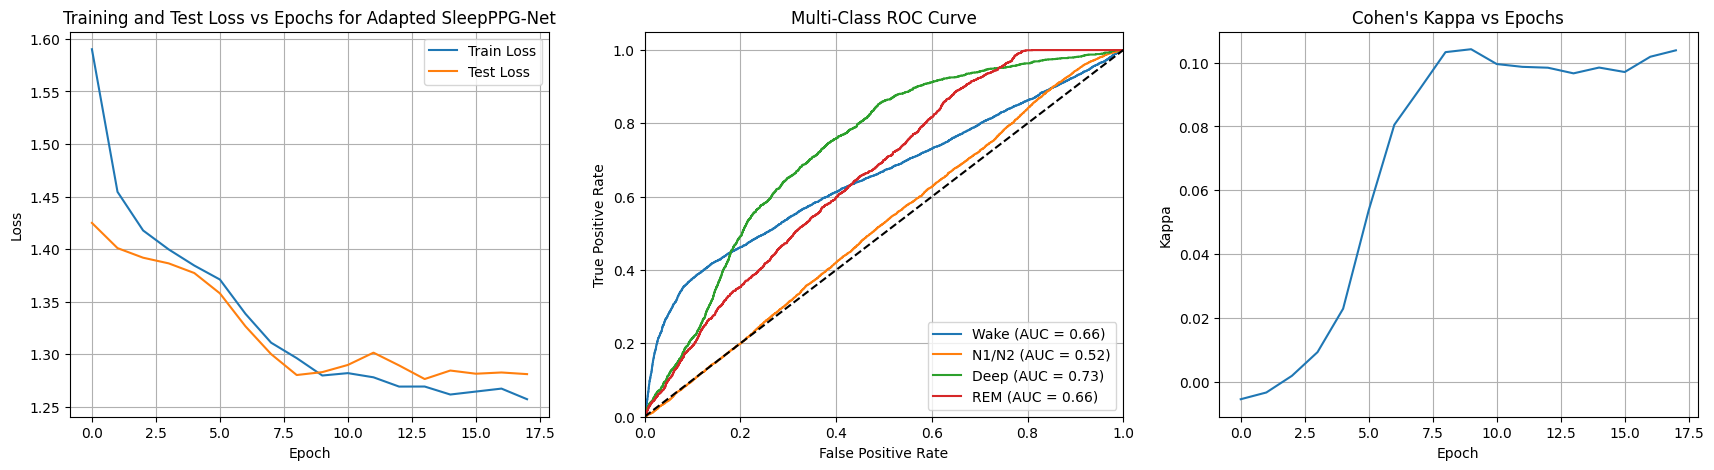

In [18]:
fig, ax = plt.subplots(ncols=3,figsize=(21,5))
# Plot the training and test losses over epochs
#plt.figure(figsize=(7, 5))
ax[0].plot(train_losses, label="Train Loss")
ax[0].plot(valid_losses, label="Test Loss")
#ax[0].set_ylim(1.2,1.6)
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()
ax[0].set_title("Training and Test Loss vs Epochs for Adapted SleepPPG-Net")
ax[0].legend()

valid_labels_ = valid_labels[-1].cpu().detach().numpy()
valid_logits_ = valid_logits[-1].cpu().detach().numpy()

y_true = pd.DataFrame(data = {i: (valid_labels_ == i).astype(int) for i in range(4)}).to_numpy()
y_score = F.softmax(valid_logits[-1].cpu().detach(),dim=1).numpy()

SLEEP_CLASS_MAPPING = {
    0: "Wake",    # Wake
    1: "N1/N2",  # non-REM stage 1 (light)
    2: "Deep",   # REM
    3: "REM"
}
n_classes = len(SLEEP_CLASS_MAPPING)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    ax[1].plot(fpr[i], tpr[i], label=f"{SLEEP_CLASS_MAPPING[i]} (AUC = {roc_auc[i]:.2f})")
ax[1].plot([0,1], [0,1], 'k--')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("Multi-Class ROC Curve")
ax[1].legend(loc="lower right")
ax[1].grid(True)

ax[2].plot(kappas)
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Kappa")
ax[2].set_title("Cohen's Kappa vs Epochs")
ax[2].grid(True)

#### Plot Test Set Confusion Matrix and Performance Metrics

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

#y_true is an array of the true label class for the sample set with shape (n_samples,) 
#y_pred is an array of the predicted class for the sample set with shape (n_samples,)
#class_mapping is a dictionary that maps the class number to the class string like shown below
class_mapping = {
    0: "Wake",    # Wake
    1: "N1/N2",  # non-REM stage 1 (light)
    2: "Deep",   # non-REM stage 3 (deep)
    3: "REM"   # REM
}

def plot_confusion_matrix_with_metrics(y_true, y_pred, class_mapping):
    class_vals = [i for i in class_mapping.keys()]
    class_names = [class_mapping[i] for i in range(len(class_vals))]
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_vals)))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float)   # row-wise percentage (sensitivity)

    # Calculate Sensitivity (Recall) and PPV (Precision)
    sensitivity = np.diag(cm) / np.sum(cm, axis=1)
    ppv = np.diag(cm) / np.sum(cm, axis=0)

    fig, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(cm_perc, annot=True, fmt='.2%', cmap='Blues', cbar=False, ax=ax)

    # Labels inside the boxes
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            perc = cm_perc[i, j]
       #     ax.text(j + 0.5, i + 0.3, f"{count:,}", 
        #            ha='center', va='center', color='black', fontsize=10)
            ax.text(j + 0.5, i + 0.75, f"{count:.0f}", 
                    ha='center', va='center', color='black', fontsize=10)

    # Set axis labels
    ax.set_xlabel('Prediction', fontsize=12)
    ax.set_ylabel('Reference', fontsize=12)

    # Set ticks
    ax.set_xticks(np.arange(len(class_vals)) + 0.5)
    ax.set_yticks(np.arange(len(class_vals)) + 0.5)

    ax.set_xticklabels(class_names, rotation=0, ha="center",fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

    # Plot PPV (precision) on top
    for j, p in enumerate(ppv):
        ax.text(j + 0.5, -0.2, f"{int(p*100) if not np.isnan(p) else 0}%", 
                ha='center', va='center', color='black', fontsize=10)

    # Plot Sensitivity (recall) on right
    for i, s in enumerate(sensitivity):
        ax.text(len(class_names) + 0.1, i + 0.5, f"{int(s*100) if not np.isnan(s) else 0}%", 
                ha='left', va='center', color='black', fontsize=10)

    # Center "PPV" label on top
    ax.text(len(class_vals) / 2, -0.5, "PPV", fontsize=14, ha='center', va='center')

    # Center "Sensitivity" label on the right
    ax.text(len(class_vals) + 0.6, len(class_vals) / 2, "Sensitivity", fontsize=13, ha='center', va='center', rotation=90)

    plt.tight_layout()
    plt.show()
    
y_pred = np.argmax(y_score,axis=1)
plot_confusion_matrix_with_metrics(valid_labels_, y_pred, class_mapping)

from sklearn.metrics import cohen_kappa_score, roc_auc_score

#evaluation metrics 
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
test_loss, test_acc, test_cohens_kappa, test_logit, test_label = evaluate(model, test_dataloader, criterion, device)
test_label_ = test_label.cpu().numpy()
mask = test_label_ != -1

y_true = test_label_[mask]
y_score = test_logit.cpu()[mask]

test_auroc = roc_auc_score(
    y_true,
    F.softmax(y_score,dim=1).numpy(),
    multi_class="ovo",
    average="macro",
)

print(f"auroc: {test_auroc:.2f}, cohen's kappa: {test_cohens_kappa:.2f}, accuracy: {test_acc: .2f}")